<a href="https://colab.research.google.com/github/MihaiDogariu/Keysight-Deep-Learning-Fundamentals/blob/main/Unit%20%238%20-%20Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders
In this notebook we will study how the autoencoder works and we will implement a particular case of it: the denoising autoencoder. The autoencoder involves the transformation of the input images into a code of a smaller size (undercomplete autoencoder) or a larger size (overcomplete autoencoder) than that of the input image.

The structure of an autoencoder is as shown in Figure 1.
<div>
  <center>
    <img src="https://drive.google.com/uc?export=view&id=13B18HaVSoVULk5uMVA4Hv9cOWyneXNV8" width="300" class="center">
    <p>Figure 1. General structure of an autoencoder.</p>
  </center>
</div>

The autoencoder consists of 2 subassemblies:
- encoder - transforms the input sample into a latent descriptor: $h=f(x)$
- decoder - transforms the latent descriptor into a sample: $r=g(h)=g(f(x))$. Ideally, $g(x) = f^{-1}(x)$, such tat $r=x$.

In order to evaluate the performance of an autoencoder, we use the mean square error:
$MSE = \frac{1}{N}\sum_{i=1}^{N}{(x_i-r_i)^2}$

A particular case of the autoencoder is the denoising autoencoder, with the structure in Figure 2.
<div>
  <center>
    <img src="https://drive.google.com/uc?export=view&id=1_Cx7qkHIA2K-x6Zx6p-wjB-ge11KaM5D" width="300" class="center">
    <p>Figure 2. General structure of a denoising autoencoder.</p>
  </center>
</div>

In this case a "corruption" of the input image is added, i.e. noise is added over the input sample and the autoencoder is forced to learn to reproduce the sample without noise. In this case:
- noisy input: $\tilde{x}=x+n$, where $n$ is white Gaussian noise
- encoder: $h=f(\tilde{x})$
- decoder: $r=g(h)=g(f(\tilde{x}))=g(f(x+n))\approx{x}$

In order to evaluate the performance of an autoencoder, we use the mean square error, just as in the case of the normal autoencoder.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [16]:
#input data normalization transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# downloading the train dataset
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# downloading the test dataset
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

In [17]:
# hyperparameters
latent_dims = 10
num_epochs = 30
batch_size = 128
capacity = 128
learning_rate = 5e-3
use_gpu = True

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [19]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x

In [20]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

    def get_latent_representation(self, x):
        return self.encoder(x)

    def get_reconstruction(self, x):
        return self.decoder(x)

In [21]:
# Function to display a single image
def display(img, img_size=28, title=""):
    plt.imshow(img.cpu().detach().numpy().reshape((img_size, img_size)), cmap='gray')
    plt.title(title)
    plt.show()

In [22]:
# Function to display a set of 10 images: original and reconstructed
def display10(original, reconstructed):
  n = 10
  plt.figure(figsize=(30, 6))
  for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original.cpu().detach().numpy()[i].squeeze())
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed.cpu().detach().numpy()[i].squeeze())
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [23]:
# Function to display a set of 10 images: original, noisy and reconstructed
def display10_denoising(original, noisy, reconstructed):
  n = 10
  plt.figure(figsize=(30, 6))
  for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(original.cpu().detach().numpy()[i].squeeze())
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy.cpu().detach().numpy()[i].squeeze())
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(reconstructed.cpu().detach().numpy()[i].squeeze())
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [24]:
def add_noise(original_batch, mean=0., std=0.2):
  noisy_batch = original_batch + std * torch.rand(size=original_batch.shape) + mean
  noisy_batch = torch.clip(noisy_batch, min=0., max=1.)
  return noisy_batch

In [25]:
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1316619


In [26]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
loss = nn.MSELoss()

# set to training mode
autoencoder.train()

denoising = True

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_loader:
        if denoising:
            noisy_image_batch = add_noise(image_batch)

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        if denoising:
            image_batch_recon = autoencoder(noisy_image_batch.to(device))
        else:
            image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        reconstruction_loss = loss(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        reconstruction_loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += reconstruction_loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] Mean reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 30] Mean reconstruction error: 0.099352
Epoch [2 / 30] Mean reconstruction error: 0.068893
Epoch [3 / 30] Mean reconstruction error: 0.067695
Epoch [4 / 30] Mean reconstruction error: 0.066352
Epoch [5 / 30] Mean reconstruction error: 0.065490
Epoch [6 / 30] Mean reconstruction error: 0.065079
Epoch [7 / 30] Mean reconstruction error: 0.063991
Epoch [8 / 30] Mean reconstruction error: 0.063705
Epoch [9 / 30] Mean reconstruction error: 0.063334
Epoch [10 / 30] Mean reconstruction error: 0.063023
Epoch [11 / 30] Mean reconstruction error: 0.062583
Epoch [12 / 30] Mean reconstruction error: 0.062463
Epoch [13 / 30] Mean reconstruction error: 0.062396
Epoch [14 / 30] Mean reconstruction error: 0.062434
Epoch [15 / 30] Mean reconstruction error: 0.062074
Epoch [16 / 30] Mean reconstruction error: 0.061935
Epoch [17 / 30] Mean reconstruction error: 0.062100
Epoch [18 / 30] Mean reconstruction error: 0.061857
Epoch [19 / 30] Mean reconstruction error: 0.061951
Epoch [2

In [27]:
# set the autoencoder in the eval() mode
autoencoder.eval()

# extract a batch of samples from the test set and run it through the denoising autoencoder
val_batch_original = next(iter(val_loader))[0]
if denoising:
    val_batch_noisy = add_noise(val_batch_original)
    val_batch_noisy = val_batch_noisy.to(device)
    val_batch_original = val_batch_original.to(device)
    val_batch_reconstructed = autoencoder(val_batch_noisy)
else:
    val_batch_original = val_batch_original.to(device)
    val_batch_reconstructed = autoencoder(val_batch_original)

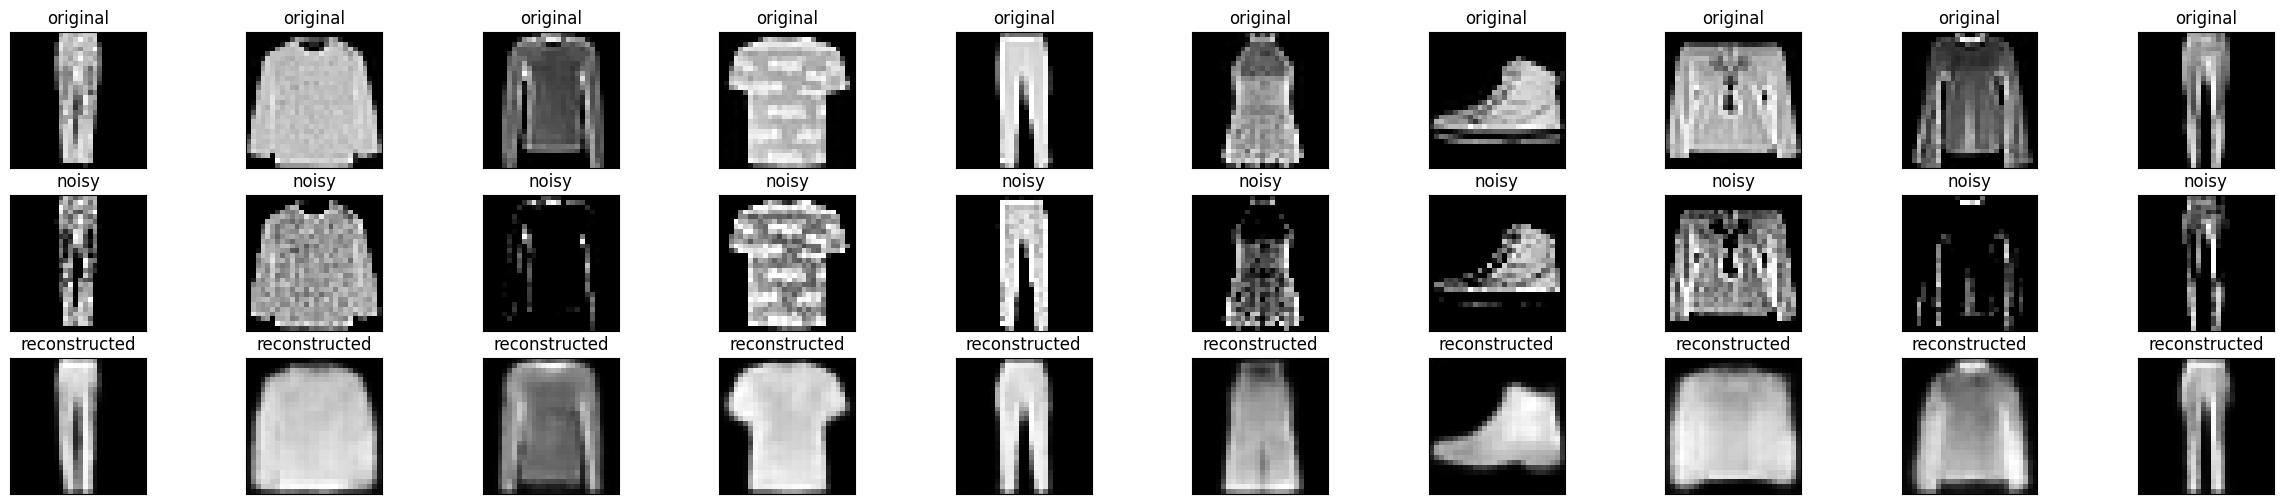

In [28]:
if denoising:
    display10_denoising(val_batch_original, val_batch_noisy, val_batch_reconstructed)
else:
    display10(val_batch_original, val_batch_reconstructed)